In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[13]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

0.00021209508879201905
10


In [2]:
chis_restricted = chis_resample[np.where((chis_resample >= chimin) & (chis_resample <= chimax))]

In [3]:
# D = np.diag(chis_restricted)

# d = D @ IHi_kappa_windowed.T
# L = np.linalg.cholesky(D @ eHIeHI @ D)
# y = np.linalg.solve(L, d)
# x = np.linalg.solve(L.T, y)
# res1 = np.einsum('ij, ji->i', d.T, x)

In [4]:
D = np.diag(chis_restricted)
d = D @ IHi_kappa_windowed.T
x = np.linalg.solve(D @ eHIeHI @ D, d)
res1 = np.einsum('ij, ji->i', d.T, x)

In [5]:
#get the denser sampling
denser_Lambda = np.logspace(-4, -1, 50)[6]
print(denser_Lambda)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, denser_Lambda,14)
denser_eIeI = np.load(oup_fname + 'eIeI.npy')
denser_eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
denser_eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
denser_eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
denser_eHIeHI = denser_eIeI + denser_eLOeLO - denser_eIeLO - denser_eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, denser_Lambda,14)
denser_IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

denser_chis_resample = np.linspace(10, chimax_sample, 2**14)
denser_window = np.where((denser_chis_resample > chimin) & (denser_chis_resample < chimax))[0]
denser_chis_restricted = denser_chis_resample[np.where((denser_chis_resample >= chimin) & (denser_chis_resample <= chimax))]
denser_IHi_kappa_windowed = denser_IHi_kappa[:, denser_window].astype(np.float64)

0.00023299518105153718


In [6]:
D = np.diag(denser_chis_restricted)

d = D @ denser_IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ denser_eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1_denser = np.einsum('ij, ji->i', d.T, x)

In [7]:
mpm_chis = mpm.linspace(np.min(chis_restricted), np.max(chis_restricted), len(chis_restricted))

In [8]:
mpm_dchi = mpm_chis[1] - mpm_chis[0]

In [9]:
results = f_eHIeHI(chimin = chimin, 
                   chimax = chimax, 
                   dchi = mpm_dchi, 
                   chis = mpm_chis, 
                   Lambda = Lambda)

import pickle
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
with open(oup_fname, 'wb') as f:
    print(oup_fname)
    pickle.dump(results, f)

Computing matrix elements: 100%|██████████| 21321/21321 [00:02<00:00, 8356.83it/s]


/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_3.50000_zmax_8.10000_Lambda_2.12095e-04_chi_sample_2e10


In [10]:
mpm_eIeI = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_eLOeLO = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_cross = np.zeros_like(eHIeHI, dtype = np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

100%|██████████| 21321/21321 [00:00<00:00, 115038.61it/s]


In [11]:
mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI = np.real(mpm_eHIeHI)

In [12]:
D = np.diag(chis_restricted)
d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ mpm_eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res2 = np.einsum('ij, ji->i', d.T, x)

# D = np.diag(chis_restricted)
# d = D @ IHi_kappa_windowed.T
# x = np.linalg.solve(D @ mpm_eHIeHI @ D, d)
# res2 = np.einsum('ij, ji->i', d.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


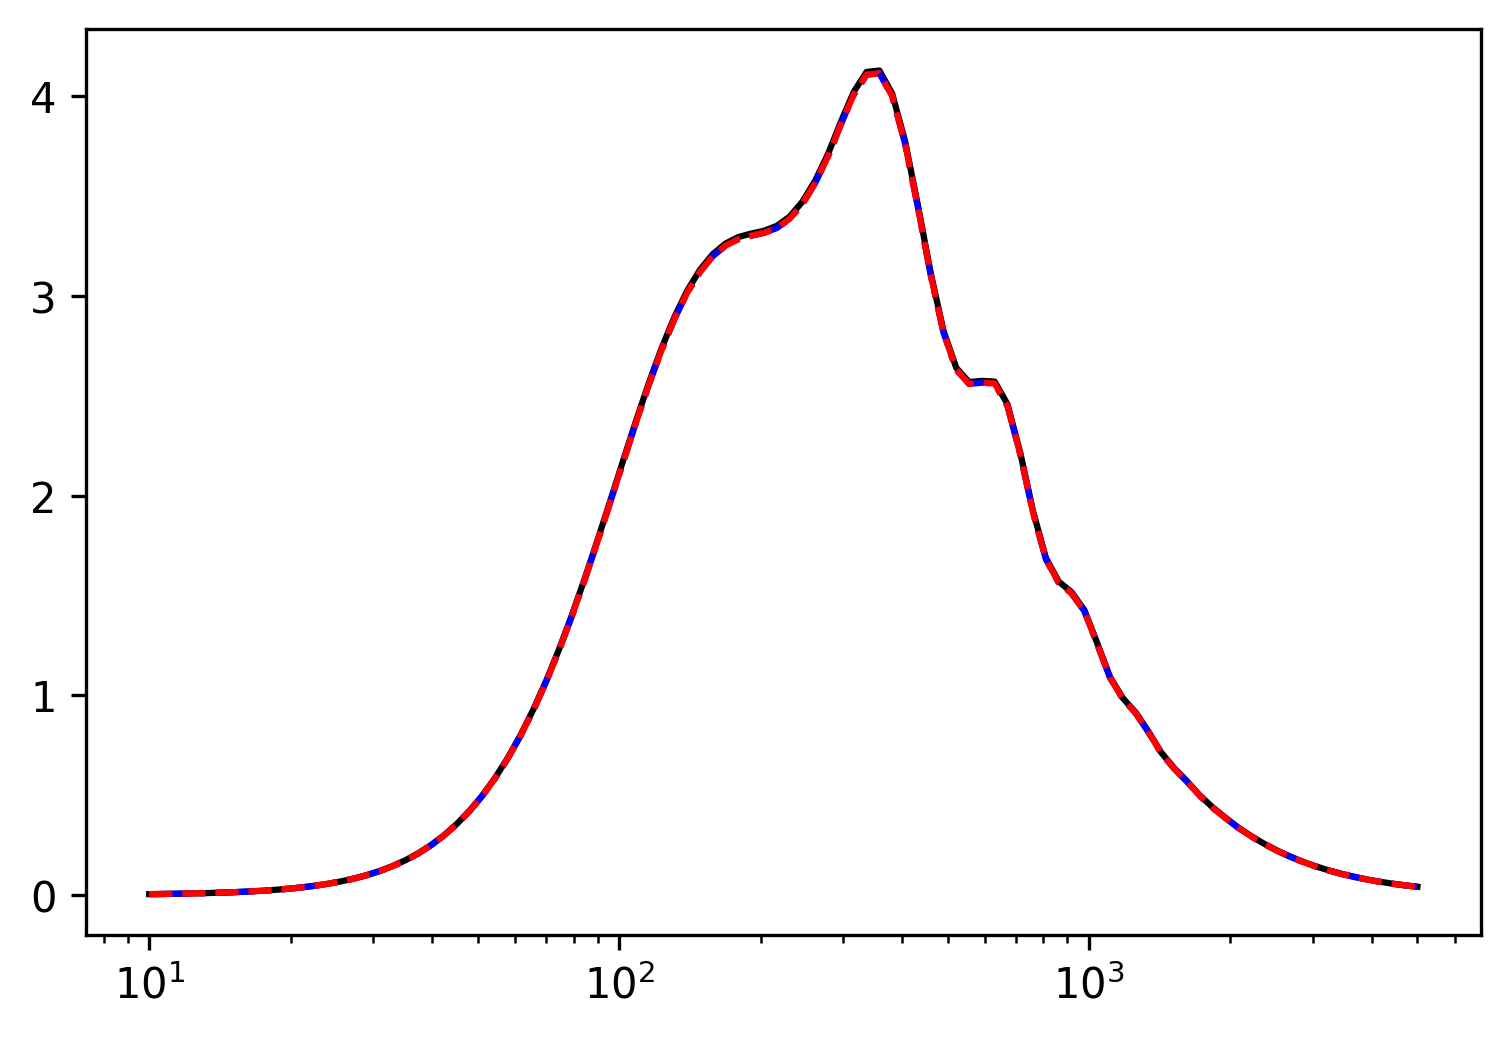

In [13]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_denser, 'k')
plt.plot(ells, ells**2 * res1, 'b-.')

plt.plot(ells, ells**2 * res2, 'r--')

plt.legend(frameon=False)
plt.xscale('log')

In [14]:
# y = np.linalg.solve(L, d)
# x = np.linalg.solve(L.T, y)
# res1 = np.einsum('ij, ji->i', d.T, x)

In [15]:
mpm_eHIeHI_not_numpy = mpm.zeros(len(window))

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eHIeHI_not_numpy[i,j] = mpm.re(_eIeI + _eLOeLO - _cross)
    mpm_eHIeHI_not_numpy[j,i] = mpm_eHIeHI_not_numpy[i,j]

100%|██████████| 21321/21321 [00:00<00:00, 104631.98it/s]


In [16]:
len(mpm_eHIeHI_not_numpy)

206

In [17]:
len(d)

206

In [18]:
res4 = [0] * len(ells)

for ell_idx in trange(len(ells)):
    d = mpm.matrix(IHi_kappa_windowed[ell_idx])
    x = mpm.cholesky_solve(mpm_eHIeHI_not_numpy, d)
    res4[ell_idx] = mpm.fdot(d, x)

100%|██████████| 100/100 [06:51<00:00,  4.12s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


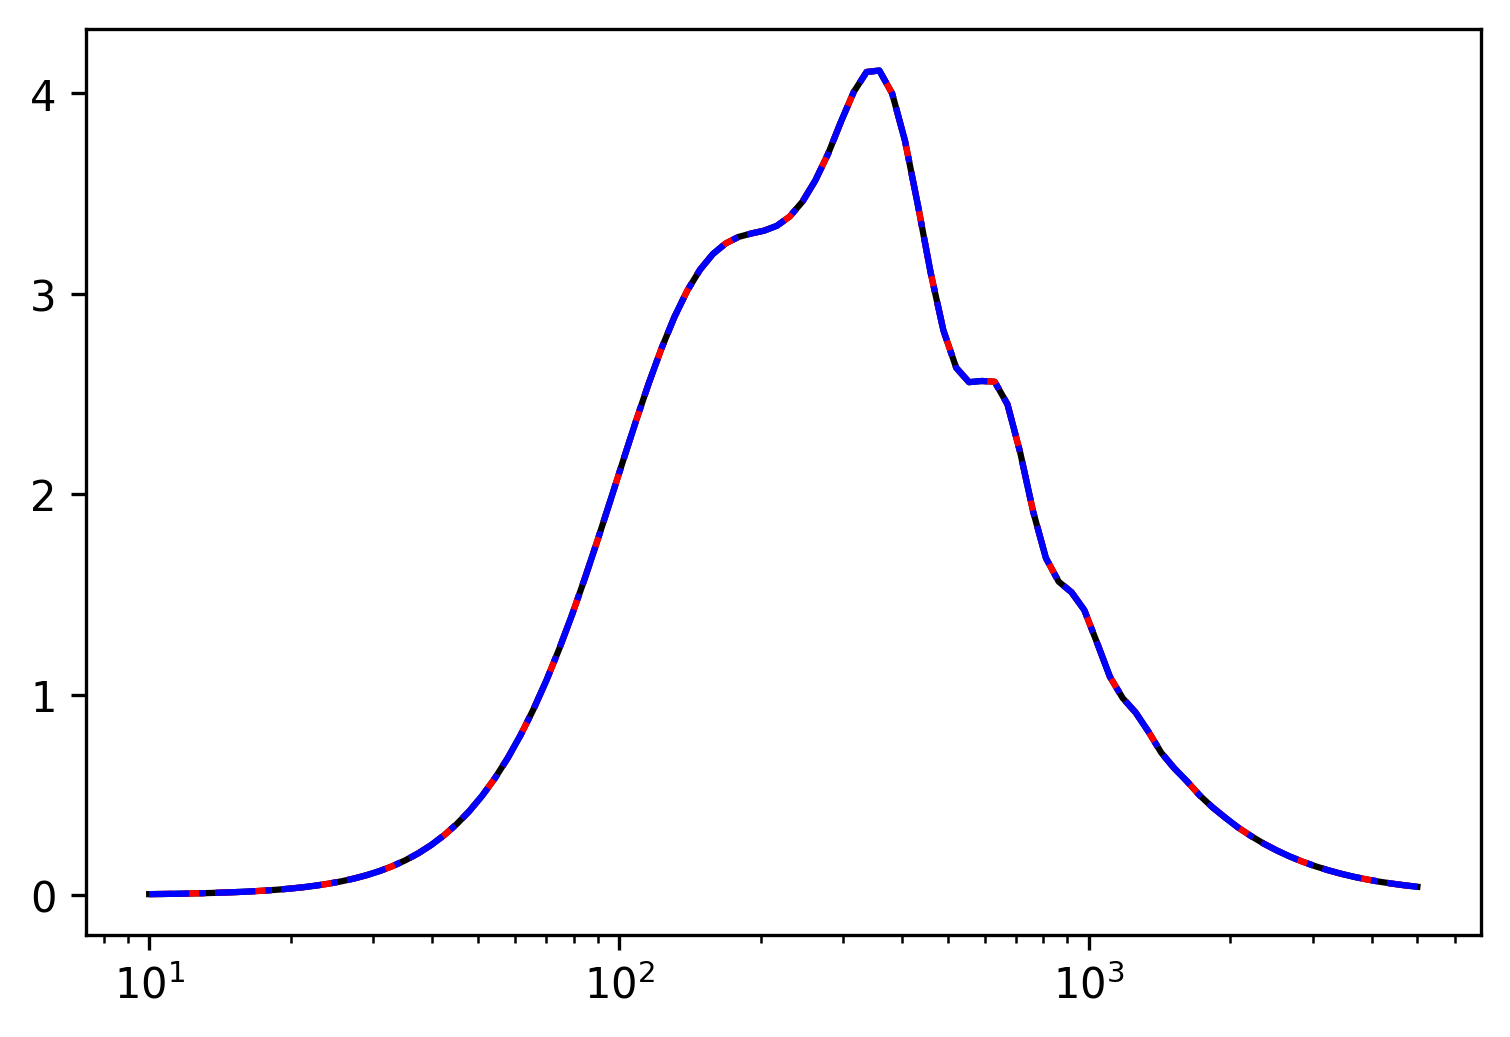

In [19]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')
plt.plot(ells, ells**2 * res4, 'b-.')

plt.legend(frameon=False)
plt.xscale('log')